Details:

https://academic.oup.com/jnci/article/104/4/311/979947

> Single sample predictors (SSPs) and Subtype classification models (SCMs) are gene expression–based classifiers used to identify the four primary molecular subtypes of breast cancer (basal-like, HER2-enriched, luminal A, and luminal B). SSPs use hierarchical clustering, followed by nearest centroid classification, based on large sets of tumor-intrinsic genes. SCMs use a mixture of Gaussian distributions based on sets of genes with expression specifically correlated with three key breast cancer genes (estrogen receptor [ER], HER2, and aurora kinase A [AURKA]). The aim of this study was to compare the robustness, classification concordance, and prognostic value of these classifiers with those of a simplified three-gene SCM in a large compendium of microarray datasets.

AURKA

ER is ESR1 (Source: https://www.genecards.org/cgi-bin/carddisp.pl?gene=ESR1)

HER2 is ERBB2 (Source: https://www.genecards.org/cgi-bin/carddisp.pl?gene=ERBB2)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
home = str(Path.home())

In [3]:
KNOWLEDGE_LIB=f'{home}/knowledgelib'

In [60]:
from IPython.display import display, Markdown, Latex
import sys
sys.path.insert(0,f'{KNOWLEDGE_LIB}')
import pyknowledge
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy.io
import pandas as pd
import numpy as np
import joblib

## Load the input data

In [84]:
## Customize this load to read in the data and format it with the correct columns
def load_data_all():
    mat = scipy.io.loadmat("/disk/metabric/BRCA1View20000.mat")
    #gene_labels = open("/disk/metabric/gene_labels.txt").read().split("\n")
    gene_labels = [g[0] for g in mat['gene'][0]]
    df = pd.DataFrame(mat['data'].transpose(), columns=gene_labels)
    df['target'] = mat['targets']
    df['Subtype'] = df.target.map({1:'Basal',2:'HER2+',3:'LumA',4:'LumB',5:'Normal Like',6:'Normal'})
    return df

def load_data_train():
    mat = scipy.io.loadmat("/disk/metabric/BRCA1View20000.mat")
    data_train = joblib.load('/disk/metabric/data_train.joblib.z')
    gene_labels = [g[0] for g in mat['gene'][0]]
    df = pd.DataFrame(data_train, columns=gene_labels)
    targets_train = joblib.load('/disk/metabric/targets_train.joblib.z')
    df['target'] = pd.DataFrame(targets_train).apply(lambda x: x.idxmax(),axis=1)+1
    df['Subtype'] = df.target.map({1:'Basal',2:'HER2+',3:'LumA',4:'LumB',5:'Normal Like',6:'Normal'})
    return df

In [85]:
df = load_data_train()

In [86]:
df.head()

,SCGB2A2,MUCL1,SCGB1D2,PIP,LOC648852,DNAJA2,TFF3,S100P,CPB1,CEACAM6,...,LOC645307,IL1RAP,LOC647149,LOC642453,LOC652100,LOC646050,LOC644912,LOC652294,target,Subtype
0,0.908510,0.139088,0.764444,0.651265,0.349056,0.567440,0.578564,0.814381,0.086647,0.362837,...,0.364566,0.079349,0.211496,0.351567,0.389877,0.413055,0.331442,0.374569,4,LumB
1,0.934538,0.049072,0.782634,0.773825,0.730930,0.634978,0.854290,0.851756,0.078594,0.320924,...,0.467865,0.171720,0.585898,0.241270,0.461529,0.309278,0.263151,0.292425,3,LumA
2,0.524853,0.406733,0.163209,0.134442,0.038088,0.094724,0.064081,0.573838,0.096810,0.235072,...,0.429290,0.290603,0.628923,0.237323,0.286573,0.320950,0.307942,0.263117,1,Basal
3,0.902295,0.147643,0.977220,0.663033,0.815075,0.604350,0.873636,0.447166,0.081619,0.426047,...,0.350638,0.128083,0.694055,0.541073,0.423310,0.409276,0.145611,0.476674,4,LumB
4,0.977377,0.240862,0.797600,0.802047,0.761589,0.083435,0.976002,0.503392,0.052166,0.558618,...,0.479229,0.297583,0.798297,0.332865,0.272482,0.239817,0.582246,0.275380,3,LumA


## Knowledge

#### Genes

In [87]:
knowledge_genes = ["ERBB2","ESR1","AURKA"]

In [88]:
genes_df = pyknowledge.common.subset_columns(df,knowledge_genes)
genes_df.head()

,ESR1,AURKA,ERBB2
0,0.687125,0.329215,0.497957
1,0.734959,0.234983,0.446970
2,0.055104,0.621349,0.373268
3,0.849794,0.396547,0.443011
4,0.848890,0.210881,0.537853


## EDA

### Each gene individually

In [89]:
source = genes_df.join(df[['Subtype','target']]).melt(id_vars=['Subtype','target'])
source.columns = ["Subtype","target","Gene","Value"]
counts = source.groupby('Subtype')['target'].count().to_frame()
counts.columns = ['Count']
source = source.set_index('Subtype').join(counts).reset_index()
# use the url approach to keep notebook smaller
url = 'three_gene_model_to_graph_fig1.json'
pyknowledge.plot.prepare_url(source,url)
# TODO: Figure out what happened to this graph
pyknowledge.plot.histogram_1(url,'Value','Subtype','Gene',file='three_gene_model_to_graph_fig1.png')

alt.Chart(...)

## Pipeline

I want this to look like a sklearn pipeline optimization where we can do a grid search. What is our objective function?

In [90]:
transformer = pyknowledge.transformers.ScaleTransformer()
methods = list(transformer.distributions.set_index('method').index)
methods

['Unscaled data',
 'Data after standard scaling',
 'Data after min-max scaling',
 'Data after max-abs scaling',
 'Data after robust scaling',
 'Data after power transformation (Yeo-Johnson)',
 'Data after power transformation (Box-Cox)',
 'Data after quantile transformation (uniform pdf)',
 'Data after quantile transformation (gaussian pdf)',
 'Data after sample-wise L2 normalizing']

In [102]:
import copy
import itertools
import json
from sklearn.pipeline import Pipeline

# Here you define your pipeline
pipe_factory = [['scaler',  lambda params: pyknowledge.transformers.ScaleTransformer(**params)],
                ['feature', lambda params: pyknowledge.transformers.FeatureSelector(**params)],
                ['knn', lambda params: pyknowledge.transformers.KNNTransformer(**params)]]
                #['distribution', lambda params: pyknowledge.transformers.DistributionTransformer(**params)]]

# Here you specify what arguments you want to search across
param_grid = {
    'scaler__method': ['Unscaled data',
                       'Data after standard scaling',
                       'Data after min-max scaling',
                       'Data after robust scaling'
                      ],
    'feature__columns': [knowledge_genes]
}

def grid_search(X,sub_types,pipe_factory,param_grid,sub_type_subset=None):
    test_dfs = []
    
    grouped = {}
    for key in param_grid.keys():
        key2,key3 = key.split("__")
        if key2 not in grouped:
            grouped[key2] = {}
        grouped[key2][key3] = param_grid[key]
    n = []

    for k in grouped.keys():
        n1 = []
        for k2 in grouped[k].keys():
            for v in grouped[k][k2]:
                n1.append((k,k2,v))
        n.append(n1)
    

    param_options = list(itertools.product(*n))
    
    if sub_type_subset is not None:
        mask = sub_types.isin(sub_type_subset)
        X = X.loc[mask]
        sub_types = sub_types[mask]

    results = None

    #print(param_options[0:3], '\n\n\n')
    for param_options1 in param_options:
        
        steps = []
        step_params = {}
        for step_name,func in pipe_factory:
            #print(step_name, func)
            cloned_params = {}
            for k1,k2,value in param_options1:
                #print(k1, k2, value)
                if k1 == step_name:
                    cloned_params[k2] = value
                    step_params[f"{step_name}__{k2}"] = value
            steps.append((step_name,func(cloned_params)))

        index_cols = list(step_params.keys())
        results1 = pd.DataFrame([],columns=['obj1']+index_cols)
        for k in index_cols:
            v = step_params[k]
            if type(v) == list:
                v = tuple(v)
            results1.loc[0,k] = v

        pipe = Pipeline(steps)
        pipe.fit(X,sub_types)
        distances, indices, labels = pipe.transform(X)
        
        sum_obj = 0
        c = 0
        for i,sub_type in enumerate(sub_types):
            count = np.sum(labels[i,:] == sub_type)
            sum_obj += count
        obj1 = sum_obj/len(sub_types)/labels.shape[1]

        results1.loc[0,'obj1'] = obj1
        
        results1.set_index(index_cols,inplace=True)
        
        if results is None:
            results = results1
        else:
            results = results.append(results1)
            
    return results.infer_objects()

In [109]:
genes_df_sample = genes_df.copy()
sub_type_subset=['Normal like', 'HER2+', 'LumB', 'LumA']
results = grid_search(genes_df_sample,df.loc[genes_df_sample.index]['Subtype'],pipe_factory,param_grid,sub_type_subset=sub_type_subset)


In [110]:
results

,,obj1
scaler__method,feature__columns,
Unscaled data,"(ERBB2, ESR1, AURKA)",0.699485
Data after standard scaling,"(ERBB2, ESR1, AURKA)",0.701416
Data after min-max scaling,"(ERBB2, ESR1, AURKA)",0.701094
Data after robust scaling,"(ERBB2, ESR1, AURKA)",0.701737


In [111]:
import joblib
joblib.dump(results,'results.joblib.z')

['results.joblib.z']

## Get the best parameters

In [115]:
best_params = {}
best = results['obj1'].idxmax()
for i,c in enumerate(results.index.names):
    best_params[c] = best[i]
best_params

{'scaler__method': 'Data after robust scaling',
 'feature__columns': ('ERBB2', 'ESR1', 'AURKA')}

In [130]:
steps = []
for name,func in pipe_factory:
    params = {}
    for key in best_params.keys():
        fields = key.split("__")
        if f"{name}__" in key:
            if type(best_params[key]) == tuple:
                best_params[key] = list(best_params[key])
            params[fields[1]] = best_params[key]
    steps.append((name,func(params)))

X = genes_df_sample.copy()
sub_types = df.loc[genes_df_sample.index]['Subtype'].copy()
if sub_type_subset is not None:
    mask = sub_types.isin(sub_type_subset)
    X = X.loc[mask]
    sub_types = sub_types[mask]
    
pipeline = Pipeline(steps)
pipeline.fit(X,sub_types)

Pipeline(steps=[('scaler',
                 ScaleTransformer(method='Data after robust scaling')),
                ('feature',
                 FeatureSelector(columns=['ERBB2', 'ESR1', 'AURKA'])),
                ('knn', KNNTransformer())])

In [132]:
distances, indices, labels = pipeline.transform(X)

In [133]:
labels

array([['LumA', 'HER2+', 'LumB'],
       ['LumA', 'LumB', 'LumA'],
       ['LumB', 'LumB', 'LumB'],
       ...,
       ['LumA', 'LumA', 'LumA'],
       ['LumB', 'LumA', 'LumB'],
       ['LumA', 'LumB', 'LumA']], dtype=object)

In [136]:
import networkx as nx
G = nx.Graph()
for i in range(len(indices)):
    for ix in indices[i,:]:
        G.add_edge(i,ix)

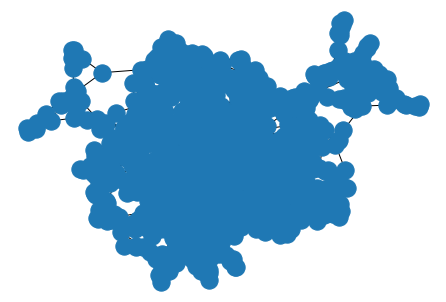

In [138]:
nx.draw(G)

## TODO: Make only the true connections